In [ ]:
#!pip3 install transformers
!pip3 install dask
!pip3 install plotly


In [ ]:
from transformers import pipeline
import torch
import tqdm as notebook_tqdm
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
import warnings
import dask.bag as db
import dask.dataframe as dd
import dask.multiprocessing
import re
warnings.filterwarnings("ignore")

In [5]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Downloading: 100%|██████████| 629/629 [00:00<00:00, 563kB/s]
2022-06-18 11:20:34.631626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-18 11:20:34.631680: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-18 11:20:34.631706: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-f6629f): /proc/driver/nvidia/version does not exist
2022-06-18 11:20:34.658362: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

In [6]:
print(type(classifier))

<class 'transformers.pipelines.text_classification.TextClassificationPipeline'>


In [7]:
classifier("I love this movie!")

[{'label': 'POSITIVE', 'score': 0.9998775720596313}]

In [8]:
classifier("i wish i liked this movie")

[{'label': 'NEGATIVE', 'score': 0.8467209339141846}]

In [9]:
classifier("I can't say that this movie was so good")

[{'label': 'NEGATIVE', 'score': 0.7528797388076782}]

In [10]:
data = pd.read_csv('/workspaces/Data-Science-Journey/Natural-Language-Processing/Transformers/Sentiment Analysis/input/AirlineTweets.csv')
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [11]:
not_nuetral_filter = data['airline_sentiment'] != 'neutral'
data = data[not_nuetral_filter]

In [12]:
data['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [13]:
target_map = {'negative': 0,  'positive': 1}
data['airline_sentiment'] = data['airline_sentiment'].map(target_map)

In [14]:
data = data[['airline_sentiment', 'text']]

In [15]:
data['text'].head(2)

1    @VirginAmerica plus you've added commercials t...
3    @VirginAmerica it's really aggressive to blast...
Name: text, dtype: object

In [13]:
data['prediction'] = classifier(data['text'].to_list())

In [14]:
data['pred_label']=data['prediction'].apply(lambda x: 1 if x['label']=='POSITIVE' else 0)

In [15]:
data['pred_prob']=data['prediction'].apply(lambda x: x['score'] if x['label']=='POSITIVE' else 1-x['score'])

In [16]:
data.head(2)

,airline_sentiment,text,prediction,pred_label,pred_prob
1,1,@VirginAmerica plus you've added commercials t...,"{'label': 'POSITIVE', 'score': 0.6070848107337...",1,0.607085
3,0,@VirginAmerica it's really aggressive to blast...,"{'label': 'NEGATIVE', 'score': 0.9973449110984...",0,0.002655


In [17]:
cm = confusion_matrix(data['airline_sentiment'], data['pred_label'], labels=[0, 1])

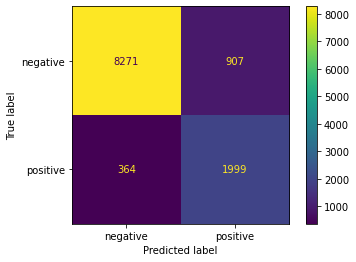

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()


In [19]:
print(classification_report(data['airline_sentiment'], data['pred_label']))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      9178
           1       0.69      0.85      0.76      2363

    accuracy                           0.89     11541
   macro avg       0.82      0.87      0.84     11541
weighted avg       0.90      0.89      0.89     11541



In [20]:
def normalize_tokens(tokenlist):
    '''
    Input: list of tokens as strings,  e.g. ['I', ' ', 'saw', ' ', '@psresnik', ' ', 'on', ' ','Twitter']
    Output: list of tokens where
    All tokens are lowercased
    All tokens starting with a whitespace character have been filtered out
    All handles (tokens starting with @) have been filtered out
    Any underscores have been replaced with + (since we use _ as a special character in bigrams)
    '''
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens

In [21]:
lines = data['text'].str.split(' ').to_list()


In [22]:
%%timeit
rewiew_clean = data['text'].str.split(' ').apply(normalize_tokens)

277 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
import dask.bag as db
review_bag = db.from_sequence(lines)

In [24]:
print(review_bag.take(1))

(['@VirginAmerica', 'plus', "you've", 'added', 'commercials', 'to', 'the', 'experience...', 'tacky.'],)


In [25]:
review_count = review_bag.count()
review_count


In [26]:
%%timeit
rewview_bag = review_bag.map(normalize_tokens)
review_bag.compute()

201 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
